In [1]:
# Importing all the necessary modules
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

### I have taken the non linear function f(x) = x + sin(x) to find koopman operator with neural network. I have used an autoencoder architechture for estimating the linear weights and find out the koopman operator. The proposed model closely follows the following model picture where x(k) and x(k+1) are present state and the next state of the nonlinear function, given as input and output of the model respectively.

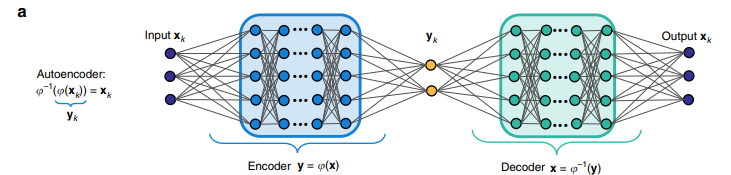

source : NATURE ARTICLE "Deep learning for universal linear embeddings of nonlinear dynamics" - Bethany Lusch 1,2, J. Nathan Kutz1 & Steven L. Brunton1,2

In [3]:
# Define the nonlinear function
def nonlinear_function(x):
    return x+np.sin(x)

num_arrays = 5000 # Number of arrays
array_size = 100 # Size of each array

# Initialize the array
data_array = np.zeros((num_arrays, array_size))
# Generate the first array x1
x1 = np.linspace(-100, 100, num_arrays)

data_array[:,0] = x1

# Generate the remaining column arrays forrepresenting the next states
for i in range(1, array_size):
    data_array[:,i] = nonlinear_function(data_array[:,i-1])
print(data_array[0:5, 0:5])

[[-100.          -99.49363436  -98.63258453  -97.68576208  -97.39369273]
 [ -99.959992    -99.41954111  -98.52321022  -97.61716719  -97.39133722]
 [ -99.919984    -99.3463128   -98.4199447   -97.56235115  -97.39023361]
 [ -99.879976    -99.27400262  -98.32284565  -97.51915404  -97.38973628]
 [ -99.83996799  -99.20266226  -98.23192005  -97.4855788   -97.3895206 ]]


In [4]:
# Initialize the output array where each column is next state of the corresponding column of the input array
data_array_op = np.zeros((num_arrays, array_size))

data_array_op[:,0:(array_size-1)] = data_array[:,1:array_size]
data_array_op[:,array_size-1] = nonlinear_function(data_array_op[:,array_size-2])

In [5]:
print(data_array_op[0:5, 0:5])

[[-99.49363436 -98.63258453 -97.68576208 -97.39369273 -97.38937227]
 [-99.41954111 -98.52321022 -97.61716719 -97.39133722 -97.38937226]
 [-99.3463128  -98.4199447  -97.56235115 -97.39023361 -97.38937226]
 [-99.27400262 -98.32284565 -97.51915404 -97.38973628 -97.38937226]
 [-99.20266226 -98.23192005 -97.4855788  -97.3895206  -97.38937226]]


In [6]:
# Split the input data into training and testing sets
# Specify the split point
split_point = int(0.8 * num_arrays)

# Split the data into training and testing sets
train_data = data_array[:split_point, :]
test_data = data_array[split_point:, :]

print(train_data[0:5, 0:5])
print(test_data.shape)

[[-100.          -99.49363436  -98.63258453  -97.68576208  -97.39369273]
 [ -99.959992    -99.41954111  -98.52321022  -97.61716719  -97.39133722]
 [ -99.919984    -99.3463128   -98.4199447   -97.56235115  -97.39023361]
 [ -99.879976    -99.27400262  -98.32284565  -97.51915404  -97.38973628]
 [ -99.83996799  -99.20266226  -98.23192005  -97.4855788   -97.3895206 ]]
(1000, 100)


In [7]:
# Split the output data into training and testing sets
train_data_op = data_array_op[:split_point, :]
test_data_op = data_array_op[split_point:, :]

print(train_data_op[0:5, 0:5])
print(test_data_op.shape)

[[-99.49363436 -98.63258453 -97.68576208 -97.39369273 -97.38937227]
 [-99.41954111 -98.52321022 -97.61716719 -97.39133722 -97.38937226]
 [-99.3463128  -98.4199447  -97.56235115 -97.39023361 -97.38937226]
 [-99.27400262 -98.32284565 -97.51915404 -97.38973628 -97.38937226]
 [-99.20266226 -98.23192005 -97.4855788  -97.3895206  -97.38937226]]
(1000, 100)


In [8]:
print(train_data[0:5, 0:5])
print(train_data_op[0:5, 0:5])

[[-100.          -99.49363436  -98.63258453  -97.68576208  -97.39369273]
 [ -99.959992    -99.41954111  -98.52321022  -97.61716719  -97.39133722]
 [ -99.919984    -99.3463128   -98.4199447   -97.56235115  -97.39023361]
 [ -99.879976    -99.27400262  -98.32284565  -97.51915404  -97.38973628]
 [ -99.83996799  -99.20266226  -98.23192005  -97.4855788   -97.3895206 ]]
[[-99.49363436 -98.63258453 -97.68576208 -97.39369273 -97.38937227]
 [-99.41954111 -98.52321022 -97.61716719 -97.39133722 -97.38937226]
 [-99.3463128  -98.4199447  -97.56235115 -97.39023361 -97.38937226]
 [-99.27400262 -98.32284565 -97.51915404 -97.38973628 -97.38937226]
 [-99.20266226 -98.23192005 -97.4855788  -97.3895206  -97.38937226]]


In [9]:
shape=(array_size,)
shape

(100,)

## Model Architechture

Input -> 3 dense layers -> 2 linear layers -> 3 dense layers -> output

In [10]:
## Making an auto encoder architechture for finding the koopman operator
# Define the encoder
input_layer = Input(shape=(array_size,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded_output = Dense(array_size, activation='relu')(encoded)

# Define linear layers in between
linear_layer = Dense(array_size, activation='linear')(encoded_output)
linear_layer = Dense(units=array_size, activation='linear')(linear_layer)

# Define the decoder with output matching the input shape
decoded = Dense(64, activation='relu')(linear_layer)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded_output = Dense(array_size, activation='tanh')(decoded)

# Combine the encoder and decoder into an autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded_output)

# Extract the encoder model
encoder_model = Model(inputs=input_layer, outputs=encoded_output)

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 100)               6500      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100 

In [12]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 100)               6500      
                                                                 
Total params: 73508 (287.14 KB)
Trainable params: 73508 (287.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Compile the autoencoder model
optimizer = 'Adam'
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error') # using mse loss function

In [14]:
# Train the autoencoder
num_epochs = 25
batch_size = 32

autoencoder.fit(train_data, train_data_op, epochs=num_epochs, batch_size=batch_size, validation_data=(test_data, test_data_op))

Epoch 1/25
125/125 [==============================] - 2s 4ms/step - loss: 2466.8433 - val_loss: 6368.3003
Epoch 2/25
125/125 [==============================] - 0s 3ms/step - loss: 2456.7915 - val_loss: 6368.3003
Epoch 3/25
125/125 [==============================] - 0s 3ms/step - loss: 2454.2844 - val_loss: 6368.3003
Epoch 4/25
125/125 [==============================] - 0s 3ms/step - loss: 2454.2109 - val_loss: 6368.3003
Epoch 5/25
125/125 [==============================] - 0s 3ms/step - loss: 2454.2109 - val_loss: 6368.3003
Epoch 6/25
125/125 [==============================] - 0s 3ms/step - loss: 2454.2109 - val_loss: 6368.3003
Epoch 7/25
125/125 [==============================] - 0s 3ms/step - loss: 2454.2109 - val_loss: 6368.3003
Epoch 8/25
125/125 [==============================] - 0s 3ms/step - loss: 2454.2114 - val_loss: 6368.3003
Epoch 9/25
125/125 [==============================] - 0s 3ms/step - loss: 2454.2109 - val_loss: 6368.3003
Epoch 10/25
125/125 [=========================

In [15]:
# Encode the data into lower dimension
encoded_data = encoder_model.predict(data_array)

# Print the shape of the encoded data as the input of the linear layer
print("Shape of encoded data:", encoded_data.shape)

157/157 [==============================] - 0s 1ms/step
Shape of encoded data: (5000, 100)


In [16]:
encoded_data

array([[  0.     ,   0.     , 128.71175, ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     , 128.71695, ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     , 128.72198, ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [  0.     , 298.57355,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     , 298.58386,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     , 298.5949 ,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)

## Extracting the linear model

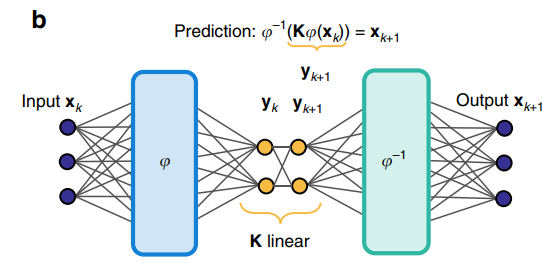

extracting from input layer of y(k) to output layer of y(k+1)

In [17]:
# Extract the linear model from the model autoencoder to find out the weights
linear_model = Model(inputs=encoded_output, outputs=linear_layer)
linear_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
Total params: 20200 (78.91 KB)
Trainable params: 20200 (78.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Size of each array
array_size = array_size
# Initialize the array
lin_array = np.zeros((num_arrays, array_size))
# Generate the first array x1
x1 = np.linspace(-3*np.pi, 3*np.pi, num_arrays)

lin_array[:,0] = x1

# Generate the remaining arrays
for i in range(1, array_size):
    lin_array[:,i] = nonlinear_function(lin_array[:,i-1])
print(lin_array.shape)

# Initialize the array
lin_array_op = np.zeros((num_arrays, array_size))
lin_array_op[:,0:array_size-1] = lin_array[:,1:array_size]
lin_array_op[:,array_size-1] = nonlinear_function(lin_array_op[:,array_size-2])

# Encode the data into lower dimension
linear_data = linear_model.predict(lin_array)

# Print the shape of the encoded data
print("Shape of linear data:", linear_data.shape)

(5000, 100)
157/157 [==============================] - 0s 1ms/step
Shape of linear data: (5000, 100)


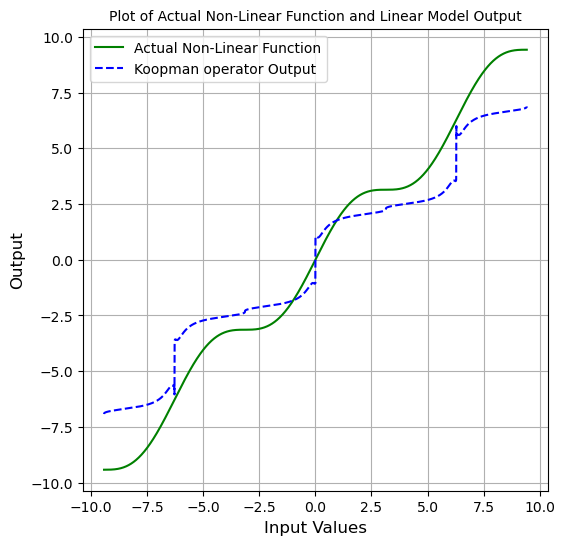

In [18]:
# Plot the actual non-linear function and the linear model's output
import matplotlib.pyplot as plt
import numpy as np

i=1
plt.figure(figsize=(6, 6))

plt.plot(lin_array[:, i], lin_array_op[:, i], label='Actual Non-Linear Function', color='green')
plt.plot(lin_array[:, i], linear_data[:, i], label='Koopman operator Output', linestyle='dashed', color='blue')

plt.title('Plot of Actual Non-Linear Function and Linear Model Output', fontsize=10)
plt.xlabel('Input Values', fontsize=12)
plt.ylabel('Output', fontsize=12)

plt.legend(loc='upper left')  # Adjust the legend location

plt.grid(True)  # Add grid lines

plt.show()

In [20]:
koopman_operator = linear_model.get_weights()
print(koopman_operator)

[array([[ 0.1311002 , -0.00418589,  0.1266438 , ...,  0.10871463,
         0.15435791,  0.06399512],
       [ 0.09753665,  0.10359903, -0.0288646 , ...,  0.11181825,
        -0.13761887,  0.00366623],
       [-0.07435913, -0.14408474,  0.07335582, ..., -0.08643966,
        -0.1617921 , -0.02294818],
       ...,
       [-0.03347534, -0.13689399, -0.06740212, ..., -0.12306757,
         0.11322278,  0.10246354],
       [ 0.11695228, -0.11887962, -0.09233312, ..., -0.07228058,
         0.12395415,  0.02010115],
       [ 0.03474497,  0.07707423,  0.0795785 , ..., -0.01999635,
        -0.09471869,  0.00284968]], dtype=float32), array([-1.1897674e-02, -9.6262246e-03, -2.8973811e-03,  9.6110050e-03,
       -6.9848895e-03,  1.8641919e-02, -5.0925271e-05,  6.6038561e-03,
        5.2868817e-03, -4.0419488e-03,  5.3595980e-03, -1.9577409e-04,
        8.7194936e-04,  9.8337710e-04,  5.7031317e-03,  4.6505523e-03,
        3.1182368e-03, -7.1016937e-03, -8.1989467e-03,  2.3145517e-03,
        3.73113

In [15]:
i=1
xt = lin_array[:,i]
yt = lin_array_op[:,i]
ypred = linear_data[:,i]

In [16]:
# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(yt,ypred)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(yt,ypred)
print(f'R-squared: {r2}')

Mean Squared Error: 2.558672877611617
R-squared: 0.9247462013619882


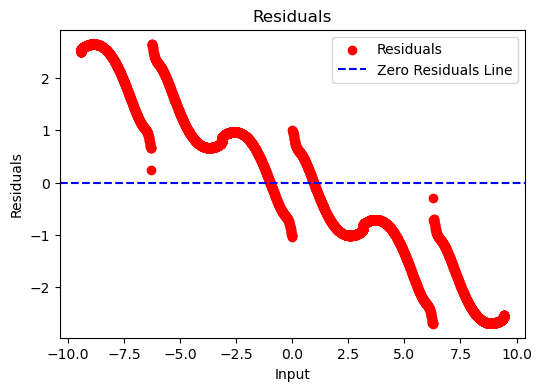

In [17]:
# Plot Residuals
residuals = ypred - yt
plt.figure(figsize=(6, 4))
plt.scatter(xt, residuals, label='Residuals', color='red')
plt.axhline(y=0, color='blue', linestyle='--', label='Zero Residuals Line')
plt.title('Residuals')
plt.xlabel('Input')
plt.ylabel('Residuals')
plt.legend()

In [24]:
# Get and save all model weights
weights_path = 'autoencodermodel_weights.h5'
autoencoder.save_weights(weights_path)

weights_path = 'linearmodel_weights.h5'
linear_model.save_weights(weights_path)

In [25]:
# Specify the file path where you want to save the array
file_path = 'lin_array.npy'
np.save(file_path, lin_array)
file_path = 'lin_array_op.npy'
np.save(file_path, lin_array_op)
file_path = 'linear_data.npy'
np.save(file_path, linear_data)